## 目的：population annealingを試す

マルコフ連鎖MCと違う点

重みが確率分布を作っていく
（重い→）

- データ
```python
'training_markers.txt','training_yields.txt'
```

- 予測アルゴリズム

χ2分類    "説明変数がカテゴリーで目的変数もカテゴリーのときは、χ2乗検定の独立性検定を用いる。"

- 最高温度

2500

始めっからK個全部入れるのは全解探索と変わらない。

In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math, warnings
from sklearn.feature_selection import SelectKBest, chi2
import pprint
import itertools

In [2]:
#valiable
num_select = 3

every_MCS = 100

#降順である{1/b}の作成
Max_temper = 2000 #最高温度（スタート地点）
b = [100/j for j in reversed(range(1, Max_temper+1))]
print("1/bのトップバッター(最大値希望)1/b[0]は{}である".format(1/b[0]))
print("1/bのラスト1/b[-1]（最小値希望）は{}である".format(1/b[-1]))

1/bのトップバッター(最大値希望)1/b[0]は20.0である
1/bのラスト1/b[-1]（最小値希望）は0.01である


In [3]:
X = pd.read_table('training_markers.txt', header=None,  sep ='\t')# 説明変数（こっちの特徴量上位5つ取り出す）
print('the following is a part of X')
#pprint.pprint(X.head())
print("X.shape is {}".format(X.shape))
print('type of X element is {}'.format(type(X[0][0])))

data_yields = pd.read_table('training_yields.txt', header=None,  sep ='\t')# 目的変数
ori_y = data_yields.T.iloc[0]
print('type of data_yields is {}'.format(type(data_yields)))
print('type of ori_y is {}'.format(type(ori_y)))

num_sample = X.shape[0]#サンプル数
num_feature = X.shape[1]#特徴量の数

#Kをはじめにlist upするyの数とする

the following is a part of X
X.shape is (20, 20)
type of X element is <class 'numpy.int64'>
type of data_yields is <class 'pandas.core.frame.DataFrame'>
type of ori_y is <class 'pandas.core.series.Series'>


In [4]:
#状態y(yの色んなパターン)を作る
y_element = range(2) #0, 1なので
y_tuple_list = list(itertools.product(y_element, repeat=num_sample))

print("type of y_tuple_list's element is {}".format(type(y_tuple_list[0])))
print(type(pd.Series(y_tuple_list[0]))) #ori_yとtypeを揃えるためこのようにしてseriesにしないといけない
print("there are {} items in y_tuple_list.".format(len(y_tuple_list)))


#はじめに用意するレプリカはK個(今回はlen(y_tuple_list)/Max_temperとしてみる。)
#すなわちもし一回もかぶらなかったら全通り制覇できる
#K = len(y_tuple_list)/Max_temper #419.4304
K = 2*210

type of y_tuple_list's element is <class 'tuple'>
<class 'pandas.core.series.Series'>
there are 1048576 items in y_tuple_list.


In [5]:
#mask_oriの計算（以降のエネルギー計算の基準となる）
#ori_y == yとなる場合だけ、E(y)==0となる仕様

selector = SelectKBest(score_func=chi2, k=num_select) #SelectKBest #chi2...分類
selector.fit(X, ori_y)
mask_ori = selector.get_support() #各特徴量を選択したか否かのmaskを取得

In [6]:
#エネルギーが0(最低)となるのがいつか基準を先に計算しておきましょう

def E(y): #毎回のmaskとyが引数、合致度合いの計算を行う
    selector = SelectKBest(score_func=chi2, k=num_select) #SelectKBest #chi2...分類
    selector.fit(X, y)
    mask_each = selector.get_support() #各特徴量を選択したか否かのmaskを取得
    
    energy_trait_sum = 0
    for i in range(len(mask_each)):
        if mask_each[i]!=mask_ori[i]:
            energy_trait_sum += 1
    return energy_trait_sum #もとのyのときのmask(これをmaskとしている)との合致度合い（大きい⇒よく合致している）

In [7]:
E(ori_y)

0

In [8]:
Ene = [] #これからi(温度)ごとに入れていく。一行に入っているのもlistにしたい(行i, 列k, 要素Ene)
y_list = [] #これからi(温度)ごとに、選択したyを記録していく。(行i, 要素num_tl)
high_P_Klist = []  #Wが大きい（Eneが小さい）の方々のメンバー(上位メンバー)所属(k)が入ったlist

for i in range(Max_temper):   
    Ene.append({})
    y_list.append([])
    for k in range(K):
        #MCS
        #𝑃(B)/𝑃(A)>random ならば状態Bを採用し，そうでなければ状態Aを採用(Bを先、Aを過去とする)
        num_tl = random.randint(0, len(y_tuple_list)-1)
        Ene[-1][k]= E(pd.Series(y_tuple_list[num_tl]))
        y_list[-1].append(num_tl)

        r = math.exp(-Ene[i][k]*b[i]-(-Ene[i-1][k]*b[i-1])) #Ene[i-1][k]*b[i-1] - Ene[i][k]*b[i] #大きいほうが良い
        #rr = math.exp(-eene[0][0]*b[3]-(-eene[1][0]*b[2])) 
        R = np.random.uniform(0.0, 1.0)
        if R > r : #乱数R > エネルギー差の大きさを用いた計算
            Ene[-1][k] = Ene[i-1][k]
            y_list[-1][k] = y_list[i-1][k]
    
    if i%every_MCS == 0:
        #Eneのi行目に数値が全部入ったら
        Ei_sorted = sorted(Ene[-1].items(), key=lambda x:x[1]) #Eの低い順にしたい
        tuple_kE_list = Ei_sorted[0:int(len(Ei_sorted)/2)] #上位の方々のメンバー情報が入ったtuple(k, Ene)が出来上がる

        #上位の方々のメンバー所属(k)が入ったlistを作る
        high_P_Klist.append([])
        for k in range(len(tuple_kE_list)):
            high_P_Klist[-1].append(tuple_kE_list[k][0])

        #下位メンバーは上位メンバーに変えてしまう
        for k in range(int(K/2)):
            if not k in high_P_Klist[-1]:
                y_list[-1][k] = high_P_Klist[-1][k]
                Ene[-1][k] = Ene[-1][high_P_Klist[-1][k]]

In [9]:
error = 0
for ll in high_P_Klist[-1]:
    if not ll in Ene[-1]:
        error += 1
print(error)

0


In [10]:
# 知りたいのはどんなyだとEneが小さいかってこと
# 最後まで残っているのはEneが小さいだろう。
# どういう変遷をしてきたのかも知りたい
pd.DataFrame(Ene)

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,2,6,6,0,4,6,6,6,4,4,...,4,6,6,6,6,6,4,4,4,4
1,6,4,4,0,6,6,6,6,4,4,...,6,2,6,6,4,6,6,6,4,6
2,2,6,6,0,6,4,6,6,6,6,...,2,2,4,4,6,6,6,6,6,6
3,6,6,4,4,6,4,4,6,4,4,...,6,4,4,6,4,6,6,4,4,6
4,6,4,6,6,6,6,4,2,6,2,...,2,6,4,4,6,6,4,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2,2,2,0,0,2,0,2,2,2,...,2,2,2,2,2,0,0,2,2,2
1996,2,2,2,0,0,2,0,2,2,2,...,2,2,2,2,2,0,0,2,2,2
1997,2,2,2,0,0,2,0,2,2,2,...,2,2,2,2,2,0,0,2,2,2
1998,2,2,2,0,0,2,0,2,2,2,...,2,2,2,2,2,0,0,2,2,2


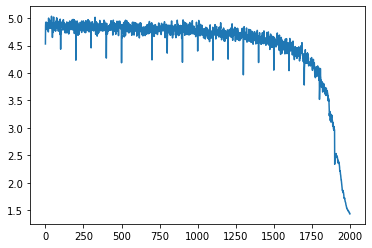

1.4333333333333333


In [11]:
Ene_v_sum_list = []
Ene_v_sum_list_append = Ene_v_sum_list.append
for each_Ene in Ene:
    Ene_v_sum = 0
    for Ene_v in each_Ene.values():
        Ene_v_sum += Ene_v
    Ene_v_sum_list_append(Ene_v_sum/K)
#Ene_v_sum_list
plt.plot(Ene_v_sum_list)
plt.show()
print(Ene_v_sum_list[-1])

In [12]:
y_list_df = pd.DataFrame(y_list)  #i(温度)ごとに、選択したyを記録していく。(行i, 要素num_tl)

y_list_df

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,581059,580317,667750,928336,101552,905525,776508,550229,310259,114200,...,393654,37443,574342,649576,542272,537910,1037718,837353,292298,434901
1,918632,738937,641785,928336,511534,857154,955571,841841,570324,698904,...,621102,595358,46434,11974,327063,891991,754711,517696,292298,252900
2,873929,450176,222075,928336,194272,242314,129465,974616,227541,832607,...,969313,680230,683881,876021,262696,563963,1034052,26668,632641,944025
3,616919,45354,613833,358700,313562,784940,595423,649071,279463,113414,...,716847,863823,849179,476989,937797,34460,96442,284456,691819,956724
4,271411,207987,582308,34544,383492,950956,438674,797555,215497,892318,...,349479,21320,727671,322117,954126,154019,617520,574839,711577,720820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,845936,766836,847105,88,133,37662,87231,985316,169872,945573,...,898495,152602,30686,942197,949860,390809,404244,234098,423049,269485
1996,845936,766836,847105,88,133,37662,87231,985316,169872,945573,...,898495,152602,30686,942197,949860,390809,404244,234098,423049,269485
1997,845936,766836,847105,88,133,37662,87231,985316,169872,945573,...,898495,152602,30686,942197,949860,390809,404244,234098,423049,269485
1998,845936,766836,847105,88,133,37662,87231,985316,169872,945573,...,898495,152602,30686,942197,949860,390809,404244,234098,423049,269485
